In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11998155193158546276, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15505193728
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14942020491704736252
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [4]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.156
cache size	: 39424 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	:

In [6]:
!free -h --si | awk  '/Mem:/{print $2}'

26G


# Install and Import Packages

In [1]:
pip install -q scikit-plot

In [2]:
pip install --upgrade coremltools

     |████████████████████████████████| 3.4MB 16.5MB/s 
  Created wheel for attr: filename=attr-0.3.1-cp37-none-any.whl size=2458 sha256=88adcf62202f97aa14f8d0f913bed8f3c6dab57d990cc53a29e8cc454dbc5b43
  Stored in directory: /root/.cache/pip/wheels/f0/96/9b/1f8892a707d17095b5a6eab0275da9d39e68e03a26aee2e726
Successfully built attr


In [3]:
pip install keras-tuner

     |████████████████████████████████| 71kB 6.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=ced302e6effba354aa1957ca7d0fbe54ffc40df6ab5ec7937c93ebc64f2167b1
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=cb0cb3cc3cedac5785fb3153ecc260c05f9742881ecda3238aca9b4152a12edf
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [4]:
import zipfile
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import random
import numpy as np
import tensorflow.keras as K
import scikitplot as skplt
import coremltools as ct
import time

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, Reshape, Input, BatchNormalization
from keras.applications import VGG16, DenseNet169
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from kerastuner import Hyperband

In [5]:
random.seed(1)
np.random.seed(1)

# Loading in and Analysing the Dataset

Extract teh zipfile into directory

In [6]:
! git clone https://github.com/arifnurrhmnn/Dataset-Motif-Batik

Cloning into 'Dataset-Motif-Batik'...
remote: Enumerating objects: 3635, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 3635 (delta 3), reused 18 (delta 2), pack-reused 3616
Receiving objects: 100% (3635/3635), 115.95 MiB | 23.58 MiB/s, done.
Resolving deltas: 100% (234/234), done.


Get the path of each class

In [7]:
CLASSES = ['kawung', 'megamendung', 'parang', 'sidomukti', 'truntum']
NUM_CLASSES = len(CLASSES)

train_path = '/content/Dataset-Motif-Batik/dataset/train'
val_path = '/content/Dataset-Motif-Batik/dataset/val'
test_path = '/content/Dataset-Motif-Batik/dataset/test'

def get_image_paths(path, motif):
  full_path = path + '/' + motif + '/*.jpg'
  return glob.glob(full_path)

train_kawung = get_image_paths(train_path, CLASSES[0])
train_megamendung = get_image_paths(train_path, CLASSES[1])
train_parang = get_image_paths(train_path, CLASSES[2])
train_sidomukti = get_image_paths(train_path, CLASSES[3])
train_truntum = get_image_paths(train_path, CLASSES[4])

val_kawung = get_image_paths(val_path, CLASSES[0])
val_megamendung = get_image_paths(val_path, CLASSES[1])
val_parang = get_image_paths(val_path, CLASSES[2])
val_sidomukti = get_image_paths(val_path, CLASSES[3])
val_truntum = get_image_paths(val_path, CLASSES[4])

test_original = get_image_paths(test_path, 'original/*')
test_rotn90 = get_image_paths(test_path, 'rotasi90/*')
test_rotn180 = get_image_paths(test_path, 'rotasi180/*')
test_rotn270 = get_image_paths(test_path, 'rotasi270/*')

See number of training images for each class

In [8]:
print("Images in the training set")
print("Number of kawung images: ", len(train_kawung))
print("Number of megamendung images: ", len(train_megamendung))
print("Number of parang images: ", len(train_parang))
print("Number of sidomukti images: ", len(train_sidomukti))
print("Number of truntum images: ", len(train_truntum))

print("-"*100)

print("Images in the validation set")
print("Number of kawung images: ", len(val_kawung))
print("Number of megamendung images: ", len(val_megamendung))
print("Number of parang images: ", len(val_parang))
print("Number of sidomukti images: ", len(val_sidomukti))
print("Number of truntum images: ", len(val_truntum))

print("-"*100)

print("Images in the test set")
print("Number of original images: ", len(test_original))
print("Number of rotated(90) images: ", len(test_rotn90))
print("Number of rotated(180) images: ", len(test_rotn180))
print("Number of rotated(270) images: ", len(test_rotn270))

Images in the training set
Number of kawung images:  560
Number of megamendung images:  560
Number of parang images:  560
Number of sidomukti images:  560
Number of truntum images:  560
----------------------------------------------------------------------------------------------------
Images in the validation set
Number of kawung images:  140
Number of megamendung images:  140
Number of parang images:  140
Number of sidomukti images:  140
Number of truntum images:  140
----------------------------------------------------------------------------------------------------
Images in the test set
Number of original images:  50
Number of rotated(90) images:  50
Number of rotated(180) images:  50
Number of rotated(270) images:  50


Display sample images from each class

In [9]:
def plot_samples(samples):
  rows = 1
  cols = 5
  width=5
  height=5
  axes=[]
  fig = plt.figure(figsize = (10,2))


  for image in range(rows*cols):
    img = mpimg.imread(samples[image])
    axes.append(fig.add_subplot(rows, cols, image+1) )
    subplot_title=(CLASSES[image])
    axes[-1].set_title(subplot_title)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
  fig.tight_layout()    
  plt.show()

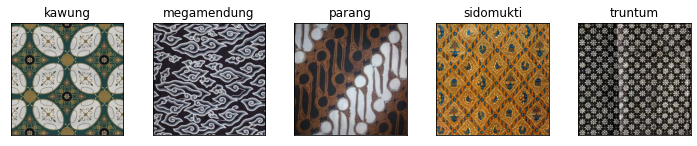

In [10]:
sample_images = []
sample_images.append(train_kawung[random.randint(0, len(train_kawung))])
sample_images.append(train_megamendung[random.randint(0, len(train_kawung))])
sample_images.append( train_parang[random.randint(0, len(train_kawung))])
sample_images.append(train_sidomukti[random.randint(0, len(train_kawung))])
sample_images.append(train_truntum[random.randint(0, len(train_kawung))])

plot_samples(sample_images)

# Functions for Evaluation

In [14]:
def plot_result(history):
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  plt.figure(figsize=(8,5))
  plt.plot(train_acc, 'lightblue', label='Training accuracy')
  plt.plot(val_acc, 'steelblue', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8,5))
  plt.plot(train_loss, 'lightblue', label='Training loss')
  plt.plot(val_loss, 'steelblue', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()


In [15]:
def model_report(test, model):
  
  x,y = test.next()
  labels = list(test.class_indices)
  y_pred = np.argmax(model.predict(x), axis=-1)
  y_pred_name = [labels[x] for x in y_pred]
  y_val =  np.argmax(y, axis=-1)
  y_val_name = [labels[x] for x in y_val]
  
  print(classification_report(y_val_name, y_pred_name))
  cm = skplt.metrics.plot_confusion_matrix(y_val_name, y_pred_name, figsize=(8,8), cmap='Blues')
  plt.show()


# Functions to Generate Dataset

In [16]:
def create_aug(preproc):
  aug_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    zoom_range=0.2,
    rotation_range=90,
    shear_range=50,
    preprocessing_function=preproc) 
  return aug_datagen

def create_data(preproc):
  reg_datagen = ImageDataGenerator(preprocessing_function=preproc) 
  return reg_datagen



In [17]:
def get_data(data, size, generator):
  dataset = generator.flow_from_directory(
    data,
    target_size=size,
    batch_size=32,
    class_mode='categorical')
  return dataset

Show examples of augmented images

In [18]:
aug_datagen = create_aug(None)
# Get augmented training images
aug_train = get_data(train_path,(224,224), aug_datagen) 
print(aug_train.class_indices)

Found 2800 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}


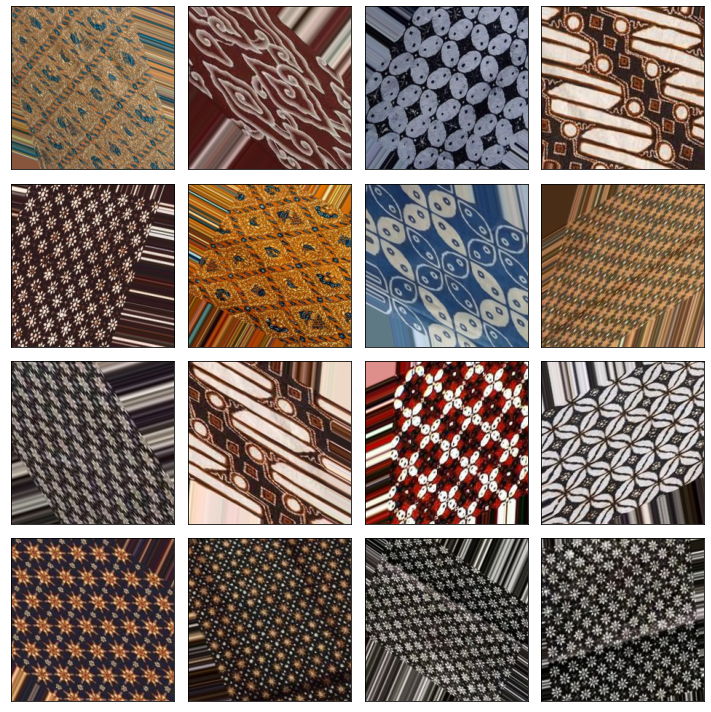

In [19]:
images, labels = aug_train.next()
fig = plt.figure(figsize = (10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  image = images[i]
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image.astype('uint8'), vmin=0, vmax=255)
# show the figure
fig.tight_layout()
plt.show()

# VGG16

## Get data

In [ ]:
TL_SIZE = (224,224)
# Get augmented training images
vgg16_aug_datagen = create_aug(K.applications.vgg16.preprocess_input)
vgg16_aug_train = get_data(train_path,TL_SIZE, vgg16_aug_datagen) 
print(vgg16_aug_train.class_indices)

# Get regular training images
vgg16_datagen = create_data(K.applications.vgg16.preprocess_input)
vgg16_train = get_data(train_path,TL_SIZE, vgg16_datagen) 
print(vgg16_train.class_indices)

# Get validation images
vgg16_val = get_data(val_path,TL_SIZE, vgg16_datagen) 
print(vgg16_val.class_indices)



Found 2800 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}
Found 2800 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}
Found 700 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}


## Create VGG16 model for transfer learning

Download the VGG16 model with imagenet weights 

In [ ]:
input_t = K.Input(shape=(224, 224, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_t)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Set block5 layers to be trainable and add final layers back in

In [ ]:
def create_vgg16():

  # Set block5 to be trainable
  for layer in vgg16.layers[:15]:
    layer.trainable = False

  for i, layer in enumerate(vgg16.layers): 
    print(i, layer.name, "-", layer.trainable)

  # Add final layers to model
  model = Sequential()
  model.add(vgg16)
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=NUM_CLASSES, activation="softmax"))

  model.compile(loss='categorical_crossentropy',
                  optimizer=K.optimizers.RMSprop(lr=1e-4),
                  metrics=['accuracy'])

  return model

In [ ]:
es_vgg = K.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
vgg16_aug_custom = create_vgg16()
vgg16_custom = create_vgg16()
vgg16_aug_custom.summary()

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - True
16 block5_conv2 - True
17 block5_conv3 - True
18 block5_pool - True
0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - True
16 block5_conv2 - True
17 block5_conv3 - True
18 block5_pool - True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape         

##Train models

### Unaugmenetd images

In [ ]:
start = time.time()
vgg16_history = vgg16_custom.fit(vgg16_train, epochs=150, verbose=1, callbacks=es_vgg, validation_data=vgg16_val)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/150
88/88 [==============================] - 36s 186ms/step - loss: 4.8702 - accuracy: 0.8135 - val_loss: 0.0233 - val_accuracy: 0.9943
Epoch 2/150
88/88 [==============================] - 12s 132ms/step - loss: 0.0722 - accuracy: 0.9946 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/150
88/88 [==============================] - 12s 132ms/step - loss: 0.3097 - accuracy: 0.9790 - val_loss: 0.0257 - val_accuracy: 0.9914
Epoch 4/150
88/88 [==============================] - 12s 132ms/step - loss: 0.0886 - accuracy: 0.9983 - val_loss: 0.0204 - val_accuracy: 0.9929
Epoch 5/150
88/88 [==============================] - 12s 130ms/step - loss: 0.0371 - accuracy: 0.9985 - val_loss: 0.1508 - val_accuracy: 0.9871
Epoch 6/150
88/88 [==============================] - 12s 131ms/step - loss: 0.3060 - accuracy: 0.9891 - val_loss: 0.0253 - val_accuracy: 0.9900
Epoch 7/150
88/88 [==============================] - 12s 132ms/step - loss: 2.8619e-06 - accuracy: 1.0000 - val_loss: 0.0332 - val_accur

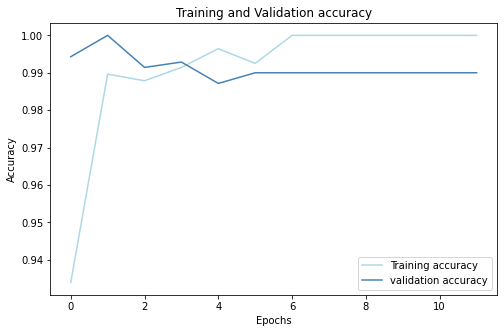

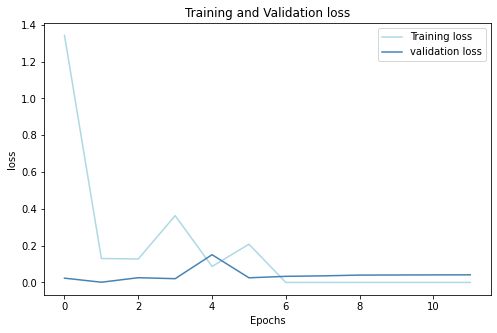

In [ ]:
plot_result(vgg16_history)

### Augmented images

In [ ]:
start = time.time()
vgg16_aug_history = vgg16_aug_custom.fit(vgg16_aug_train, epochs=150, verbose=1, callbacks=es_vgg, validation_data=vgg16_val)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/150
88/88 [==============================] - 40s 439ms/step - loss: 1.0380 - accuracy: 0.7289 - val_loss: 0.0523 - val_accuracy: 0.9900
Epoch 2/150
88/88 [==============================] - 38s 431ms/step - loss: 0.3189 - accuracy: 0.9682 - val_loss: 0.0465 - val_accuracy: 0.9871
Epoch 3/150
88/88 [==============================] - 38s 429ms/step - loss: 0.3987 - accuracy: 0.9750 - val_loss: 0.0833 - val_accuracy: 0.9829
Epoch 4/150
88/88 [==============================] - 38s 429ms/step - loss: 0.1312 - accuracy: 0.9807 - val_loss: 0.0547 - val_accuracy: 0.9900
Epoch 5/150
88/88 [==============================] - 38s 429ms/step - loss: 0.1082 - accuracy: 0.9892 - val_loss: 0.2927 - val_accuracy: 0.9871
Epoch 6/150
88/88 [==============================] - 38s 431ms/step - loss: 0.1749 - accuracy: 0.9880 - val_loss: 0.0037 - val_accuracy: 0.9986
Epoch 7/150
88/88 [==============================] - 38s 433ms/step - loss: 0.4075 - accuracy: 0.9829 - val_loss: 0.0073 - val_accuracy:

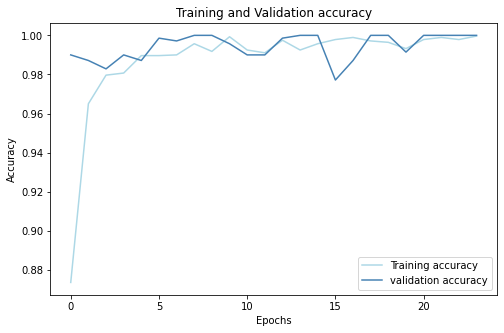

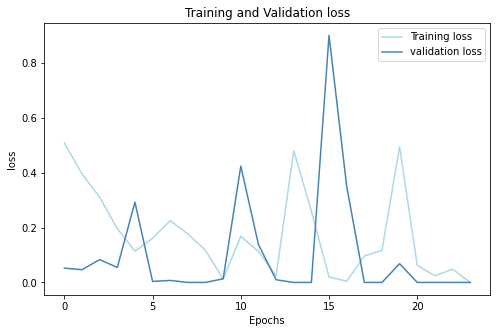

In [ ]:
plot_result(vgg16_aug_history)

# DenseNet169

## Get data

In [ ]:
# Get augmented training images
dense_aug_datagen = create_aug(K.applications.densenet.preprocess_input)
dense_aug_train = get_data(train_path,TL_SIZE, dense_aug_datagen) 
print(dense_aug_train.class_indices)

# Get regular training images
dense_datagen = create_data(K.applications.densenet.preprocess_input)
dense_train = get_data(train_path,TL_SIZE, dense_datagen) 
print(dense_train.class_indices)

# Get validation images
dense_val = get_data(val_path,TL_SIZE, dense_datagen) 
print(vgg16_val.class_indices)

Found 2800 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}
Found 2800 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}
Found 700 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}


## Create DenseNet169 Model for Transfer Learning

In [ ]:
input_t = K.Input(shape=(224, 224, 3))
densenet169 = DenseNet169(include_top=False, weights='imagenet', input_tensor=input_t)

51879936/51877672 [==============================] - 2s 0us/step


In [ ]:
densenet169.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
def create_densenet169():

  # Set block5 to be trainable
  for layer in densenet169.layers[:369]:
    layer.trainable = False

  for i, layer in enumerate(densenet169.layers): 
    print(i, layer.name, "-", layer.trainable)

  # Add final layers to model
  model = Sequential()
  model.add(densenet169)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(units=NUM_CLASSES, activation="softmax"))

  model.compile(loss='categorical_crossentropy',
                  optimizer=K.optimizers.RMSprop(lr=1e-4),
                  metrics=['accuracy'])

  return model

In [ ]:
es_dense = K.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
dense_aug_custom = create_densenet169()
dense_custom = create_densenet169()
dense_aug_custom.summary()

0 input_2 - False
1 zero_padding2d - False
2 conv1/conv - False
3 conv1/bn - False
4 conv1/relu - False
5 zero_padding2d_1 - False
6 pool1 - False
7 conv2_block1_0_bn - False
8 conv2_block1_0_relu - False
9 conv2_block1_1_conv - False
10 conv2_block1_1_bn - False
11 conv2_block1_1_relu - False
12 conv2_block1_2_conv - False
13 conv2_block1_concat - False
14 conv2_block2_0_bn - False
15 conv2_block2_0_relu - False
16 conv2_block2_1_conv - False
17 conv2_block2_1_bn - False
18 conv2_block2_1_relu - False
19 conv2_block2_2_conv - False
20 conv2_block2_concat - False
21 conv2_block3_0_bn - False
22 conv2_block3_0_relu - False
23 conv2_block3_1_conv - False
24 conv2_block3_1_bn - False
25 conv2_block3_1_relu - False
26 conv2_block3_2_conv - False
27 conv2_block3_concat - False
28 conv2_block4_0_bn - False
29 conv2_block4_0_relu - False
30 conv2_block4_1_conv - False
31 conv2_block4_1_bn - False
32 conv2_block4_1_relu - False
33 conv2_block4_2_conv - False
34 conv2_block4_concat - False
35 c

## Train Models

### Unaugmented images

In [ ]:
start = time.time()
dense_history = dense_custom.fit(dense_train, epochs=150, verbose=1, callbacks=es_dense, validation_data=dense_val)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/150
88/88 [==============================] - 34s 185ms/step - loss: 0.2040 - accuracy: 0.9398 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 2/150
88/88 [==============================] - 12s 132ms/step - loss: 7.5875e-04 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 3/150
88/88 [==============================] - 12s 133ms/step - loss: 3.3702e-04 - accuracy: 1.0000 - val_loss: 9.3909e-04 - val_accuracy: 1.0000
Epoch 4/150
88/88 [==============================] - 12s 133ms/step - loss: 4.2535e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 5/150
88/88 [==============================] - 12s 135ms/step - loss: 9.1274e-06 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/150
88/88 [==============================] - 12s 132ms/step - loss: 4.1259e-06 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/150
88/88 [==============================] - 12s 133ms/step - loss: 5.3045e-06 - accuracy: 1.0000 - val_

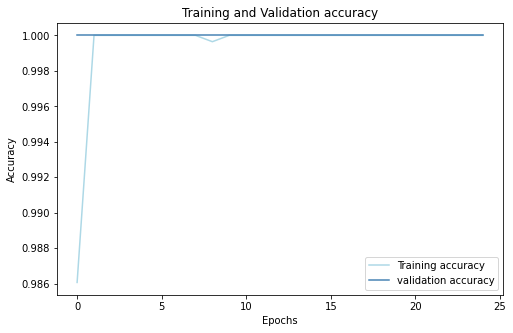

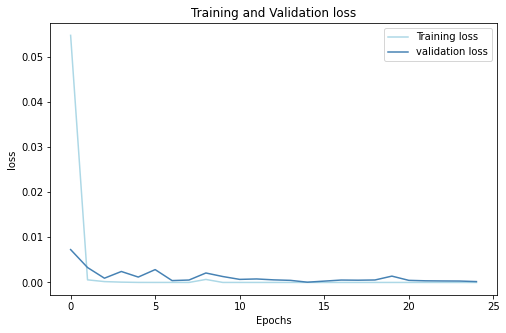

In [ ]:
plot_result(dense_history)

### Augmented images

In [ ]:
start = time.time()
dense_aug_history = dense_aug_custom.fit(dense_aug_train, epochs=150, verbose=1, callbacks=es_dense, validation_data=dense_val)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/150
88/88 [==============================] - 57s 452ms/step - loss: 0.2437 - accuracy: 0.9209 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/150
88/88 [==============================] - 37s 415ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/150
88/88 [==============================] - 37s 414ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 8.7998e-04 - val_accuracy: 1.0000
Epoch 4/150
88/88 [==============================] - 37s 417ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 3.2361e-04 - val_accuracy: 1.0000
Epoch 5/150
88/88 [==============================] - 37s 416ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 7.7998e-04 - val_accuracy: 1.0000
Epoch 6/150
88/88 [==============================] - 37s 414ms/step - loss: 4.4676e-04 - accuracy: 0.9999 - val_loss: 1.1656e-04 - val_accuracy: 1.0000
Epoch 7/150
88/88 [==============================] - 37s 416ms/step - loss: 0.0077 - accuracy: 0.9986 - val_loss: 1.

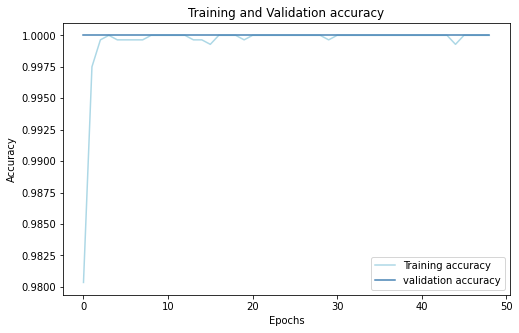

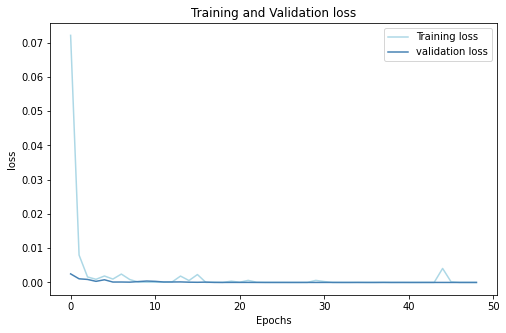

In [ ]:
plot_result(dense_aug_history)

# CNN From Scratch



## Get Data

In [32]:
def cnn_preproc(x):
  x = np.array(x).astype('float32')
  x /= 255   
  return x

In [33]:
IMG_SIZE = (32,32)
cnn_datagen = create_data(cnn_preproc)
 # Get regular training images
cnn_train = get_data(train_path,IMG_SIZE, cnn_datagen) 
print(cnn_train.class_indices)

# Get validation images
cnn_val = get_data(val_path,IMG_SIZE, cnn_datagen) 
print(cnn_val.class_indices)

Found 2800 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}
Found 700 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}


## Create CNN

In [ ]:
def build_cnn(input_shape):
  model = Sequential()
  model.add(Convolution2D(filters=32, kernel_size=(2,2), strides=1, padding='same', activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(filters=50, kernel_size=(2,2), strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(filters=80, kernel_size=(2,2), strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(40, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))


  model.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])
  
  return model

In [ ]:
cnn = build_cnn((32,32,3))
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 50)        6450      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 80)          16080     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 80)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 80)         

In [50]:
es_cnn = K.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=30,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

## Train Model

### Unaugmented images

In [ ]:
start = time.time()
cnn_history = cnn.fit(cnn_train, batch_size=32, epochs=150, verbose=1, validation_data=cnn_val, callbacks=es_cnn)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/150
88/88 [==============================] - 7s 75ms/step - loss: 1.5329 - accuracy: 0.2825 - val_loss: 1.2452 - val_accuracy: 0.5014
Epoch 2/150
88/88 [==============================] - 6s 72ms/step - loss: 1.1133 - accuracy: 0.5577 - val_loss: 0.8140 - val_accuracy: 0.6814
Epoch 3/150
88/88 [==============================] - 6s 70ms/step - loss: 0.8129 - accuracy: 0.6735 - val_loss: 0.6381 - val_accuracy: 0.7757
Epoch 4/150
88/88 [==============================] - 6s 70ms/step - loss: 0.6531 - accuracy: 0.7568 - val_loss: 0.6030 - val_accuracy: 0.8186
Epoch 5/150
88/88 [==============================] - 6s 71ms/step - loss: 0.5522 - accuracy: 0.8039 - val_loss: 0.4742 - val_accuracy: 0.8786
Epoch 6/150
88/88 [==============================] - 6s 72ms/step - loss: 0.4443 - accuracy: 0.8497 - val_loss: 0.5087 - val_accuracy: 0.8557
Epoch 7/150
88/88 [==============================] - 6s 73ms/step - loss: 0.3571 - accuracy: 0.8806 - val_loss: 0.4074 - val_accuracy: 0.8643
Epoch 

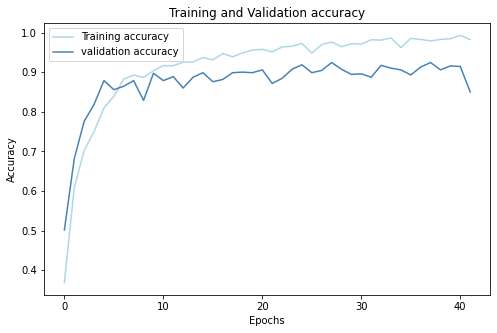

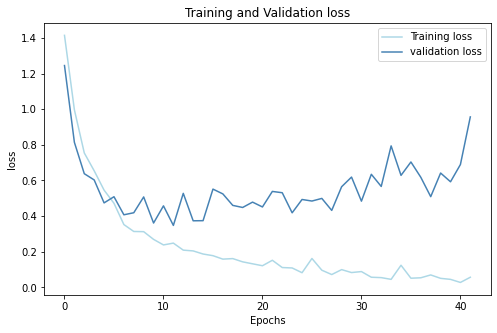

In [ ]:
plot_result(cnn_history)

# Checking Model Sizes

In [ ]:
cnn.save('/content/cnn.h5')
cnn_size = os.path.getsize('cnn.h5')
print('Size of trained CNN model: ', cnn_size/(1<<20), 'megabytes')

vgg16_custom.save('/content/vgg16.h5')
vgg16_size = os.path.getsize('vgg16.h5')
print('Size of trained VGG16 model: ', vgg16_size/(1<<20), 'megabytes')

vgg16_aug_custom.save('/content/vgg16aug.h5')
vgg16_aug_size = os.path.getsize('vgg16aug.h5')
print('Size of trained aug VGG16 model: ', vgg16_aug_size/(1<<20), 'megabytes')

dense_custom.save('/content/dense.h5')
dense_size = os.path.getsize('dense.h5')
print('Size of trained DenseNet169 model: ', dense_size/(1<<20), 'megabytes')

dense_aug_custom.save('/content/denseaug.h5')
dense_aug_size = os.path.getsize('denseaug.h5')
print('Size of trained aug aug DenseNet169 model: ', dense_aug_size/(1<<20), 'megabytes')

Size of trained CNN model:  0.9041595458984375 megabytes
Size of trained VGG16 model:  995.4380035400391 megabytes
Size of trained aug VGG16 model:  995.43798828125 megabytes
Size of trained DenseNet169 model:  72.16051483154297 megabytes
Size of trained aug aug DenseNet169 model:  72.1604995727539 megabytes


# Improving Chosen Model

## Tuning Hyperparameters

In [38]:
def tune_cnn(hp):
  model = Sequential()
  model.add(Convolution2D(filters=32, kernel_size=(2,2), strides=1, padding='same', activation='relu', input_shape=(32,32,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(filters=50, kernel_size=(2,2), strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(filters=80, kernel_size=(2,2), strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(40, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

  model.compile(
      optimizer=K.optimizers.Adam(lr),
      loss = 'categorical_crossentropy',
      metrics = ['accuracy'])
  return model

In [39]:
tuner = Hyperband(
    tune_cnn,
    objective='val_accuracy',
    max_epochs=20,
    executions_per_trial=5,
    seed=1
)

In [40]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [41]:
TRAIN_EPOCHS = 100
tuner.search(cnn_train,
             epochs=TRAIN_EPOCHS,
             validation_data=cnn_val)

Trial 3 Complete [00h 01m 35s]
val_accuracy: 0.7651428580284119

Best val_accuracy So Far: 0.7651428580284119
Total elapsed time: 00h 05m 03s


In [42]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.7651428580284119
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.6337142825126648
Trial summary
Hyperparameters:
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.5380000054836274


In [43]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [44]:
print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.001.



In [45]:
def opt_cnn(input):
  model = Sequential()
  model.add(Convolution2D(filters=32, kernel_size=(2,2), strides=1, padding='same', activation='relu', input_shape=input))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(filters=50, kernel_size=(2,2), strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(filters=80, kernel_size=(2,2), strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(40, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(
      optimizer=K.optimizers.Adam(best_hps.get('learning_rate')),
      loss = 'categorical_crossentropy',
      metrics = ['accuracy'])
  return model

## Using Larger Images

In [ ]:
rows = 1
cols = 5
width=5
height=5
axes=[]
fig = plt.figure(figsize = (10,2))

for image in range(rows*cols):
    img = mpimg.imread(sample_images[image])
    img = cv2.resize(img, (32,32))
    axes.append(fig.add_subplot(rows, cols, image+1) )
    subplot_title=(CLASSES[image])
    axes[-1].set_title(subplot_title)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
fig.tight_layout()    
plt.show()

In [ ]:
rows = 1
cols = 5
width=5
height=5
axes=[]
fig = plt.figure(figsize = (10,2))

for image in range(rows*cols):
    img = mpimg.imread(sample_images[image])
    img = cv2.resize(img, (128,128))
    axes.append(fig.add_subplot(rows, cols, image+1) )
    subplot_title=(CLASSES[image])
    axes[-1].set_title(subplot_title)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
fig.tight_layout()    
plt.show()

In [28]:
 LG_SIZE = (128,128)
 # Get regular training images
cnn_train_large = get_data(train_path,LG_SIZE, cnn_datagen) 
print(cnn_train.class_indices)

# Get validation images
cnn_val_large = get_data(val_path,LG_SIZE, cnn_datagen) 
print(cnn_val.class_indices)

NameError: ignored

In [ ]:
large_cnn = opt_cnn((128,128,3))
start = time.time()
large_cnn_history = large_cnn.fit(cnn_train_large, batch_size=32, epochs=150, verbose=1, validation_data=cnn_val_large, callbacks=es_cnn)
stop = time.time()
print(f"Training time: {stop - start}s")

In [ ]:
plot_result(large_cnn_history)

## Grayscale Images

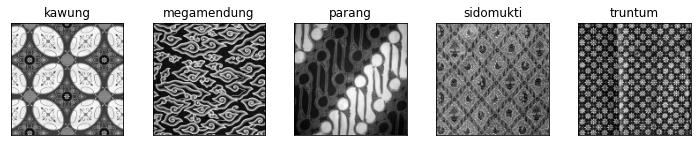

In [51]:
rows = 1
cols = 5
width=5
height=5
axes=[]
fig = plt.figure(figsize = (10,2))

for image in range(rows*cols):
    img = cv2.imread(sample_images[image])
    img = cv2.resize(img, (128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    axes.append(fig.add_subplot(rows, cols, image+1) )
    subplot_title=(CLASSES[image])
    axes[-1].set_title(subplot_title)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
fig.tight_layout()    
plt.show()

In [52]:
def get_data_g(data, size, generator):
  dataset = generator.flow_from_directory(
    data,
    target_size=size,
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')
  return dataset

In [53]:
# Get regular training images
gray_cnn_train = get_data_g(train_path,LG_SIZE, cnn_datagen) 
print(gray_cnn_train.class_indices)

# Get validation images
gray_cnn_val = get_data_g(val_path,LG_SIZE, cnn_datagen) 
print(gray_cnn_val.class_indices)

Found 2800 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}
Found 700 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}


In [54]:
gray_cnn = opt_cnn((128,128,1))
start = time.time()
gray_cnn_history = gray_cnn.fit(gray_cnn_train, batch_size=32, epochs=150, verbose=1, validation_data=gray_cnn_val, callbacks=es_cnn)
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/150
88/88 [==============================] - 8s 80ms/step - loss: 1.4719 - accuracy: 0.3288 - val_loss: 0.9523 - val_accuracy: 0.6271
Epoch 2/150
88/88 [==============================] - 7s 76ms/step - loss: 0.9565 - accuracy: 0.5753 - val_loss: 0.7105 - val_accuracy: 0.6857
Epoch 3/150
88/88 [==============================] - 7s 78ms/step - loss: 0.7628 - accuracy: 0.6637 - val_loss: 0.6368 - val_accuracy: 0.7629
Epoch 4/150
88/88 [==============================] - 7s 78ms/step - loss: 0.6918 - accuracy: 0.7155 - val_loss: 0.4448 - val_accuracy: 0.8386
Epoch 5/150
88/88 [==============================] - 7s 78ms/step - loss: 0.5414 - accuracy: 0.7961 - val_loss: 0.3799 - val_accuracy: 0.8814
Epoch 6/150
88/88 [==============================] - 7s 78ms/step - loss: 0.4785 - accuracy: 0.8240 - val_loss: 0.2707 - val_accuracy: 0.9143
Epoch 7/150
88/88 [==============================] - 7s 77ms/step - loss: 0.3917 - accuracy: 0.8494 - val_loss: 0.2251 - val_accuracy: 0.9414
Epoch 

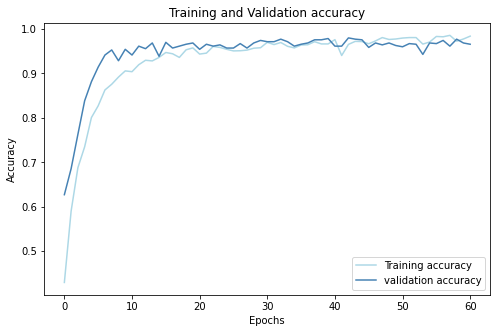

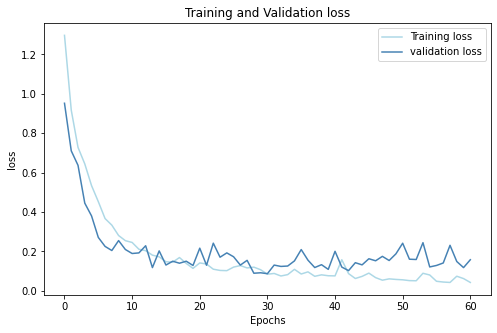

In [55]:
plot_result(gray_cnn_history)

# Test

In [56]:
def get_test(datagen, path, size, color):
  test = datagen.flow_from_directory(
      path,
      target_size=size,
      color_mode=color,
      batch_size=50,
      class_mode='categorical')
  return test


## CNN from scratch

In [57]:
test = get_test(cnn_datagen, (test_path + '/original'), LG_SIZE, 'grayscale')
print(test.class_indices)
test90 = get_test(cnn_datagen, (test_path + '/rotasi90'), LG_SIZE, 'grayscale')
print(test90.class_indices)
test180 = get_test(cnn_datagen, (test_path + '/rotasi180'), LG_SIZE, 'grayscale')
print(test180.class_indices)
test270 = get_test(cnn_datagen, (test_path + '/rotasi270'), LG_SIZE, 'grayscale')
print(test270.class_indices)


Found 50 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}
Found 50 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}
Found 50 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}
Found 50 images belonging to 5 classes.
{'kawung': 0, 'megamendung': 1, 'parang': 2, 'sidomukti': 3, 'truntum': 4}


Test on original images
              precision    recall  f1-score   support

      kawung       1.00      1.00      1.00        10
 megamendung       1.00      1.00      1.00        10
      parang       1.00      1.00      1.00        10
   sidomukti       1.00      0.60      0.75        10
     truntum       0.71      1.00      0.83        10

    accuracy                           0.92        50
   macro avg       0.94      0.92      0.92        50
weighted avg       0.94      0.92      0.92        50



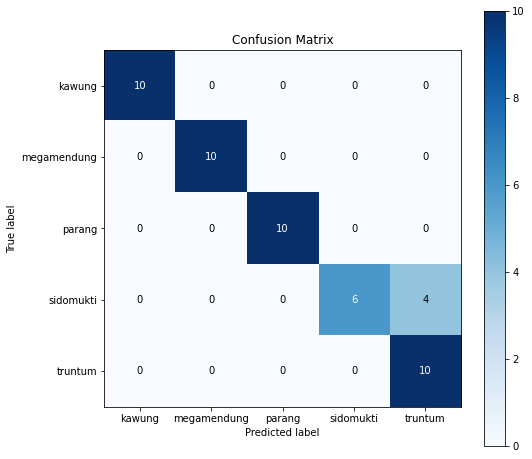

In [58]:
print("Test on original images")
model_report(test, gray_cnn)

Test on 90 degree rotated images
              precision    recall  f1-score   support

      kawung       0.91      1.00      0.95        10
 megamendung       1.00      1.00      1.00        10
      parang       1.00      0.80      0.89        10
   sidomukti       0.46      0.60      0.52        10
     truntum       0.50      0.40      0.44        10

    accuracy                           0.76        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.77      0.76      0.76        50



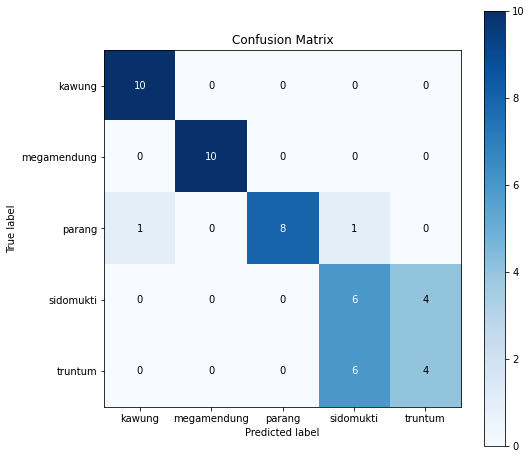

In [59]:
print("Test on 90 degree rotated images")
model_report(test90, gray_cnn)

Test on 180 degree rotated images
              precision    recall  f1-score   support

      kawung       1.00      1.00      1.00        10
 megamendung       1.00      1.00      1.00        10
      parang       1.00      1.00      1.00        10
   sidomukti       0.50      0.60      0.55        10
     truntum       0.50      0.40      0.44        10

    accuracy                           0.80        50
   macro avg       0.80      0.80      0.80        50
weighted avg       0.80      0.80      0.80        50



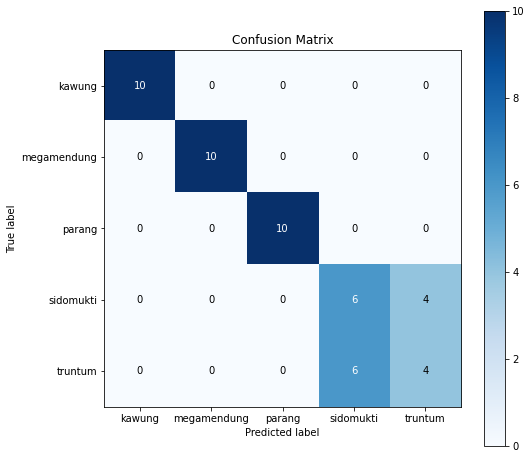

In [60]:
print("Test on 180 degree rotated images")
model_report(test180, gray_cnn)

Test on 270 degree rotated images
              precision    recall  f1-score   support

      kawung       0.91      1.00      0.95        10
 megamendung       1.00      1.00      1.00        10
      parang       1.00      0.90      0.95        10
   sidomukti       0.50      0.60      0.55        10
     truntum       0.50      0.40      0.44        10

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.78      0.78      0.78        50



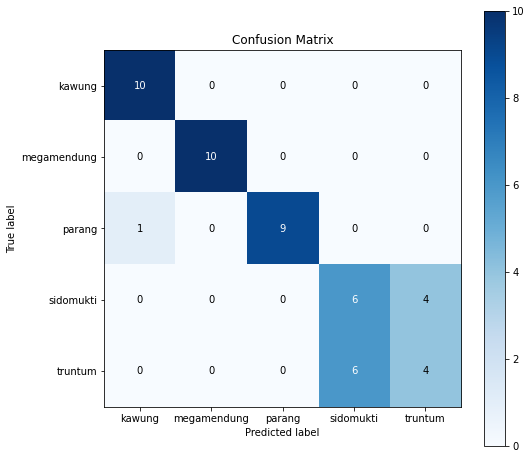

In [61]:
print("Test on 270 degree rotated images")
model_report(test270, gray_cnn)

## VGG16

In [62]:
test = get_test(vgg16_datagen, (test_path + '/original'), TL_SIZE, 'rgb')
print(test.class_indices)
test90 = get_test(vgg16_datagen, (test_path + '/rotasi90'), TL_SIZE, 'rgb')
print(test90.class_indices)
test180 = get_test(vgg16_datagen, (test_path + '/rotasi180'), TL_SIZE, 'rgb')
print(test180.class_indices)
test270 = get_test(vgg16_datagen, (test_path + '/rotasi270'), TL_SIZE, 'rgb')
print(test270.class_indices)

NameError: ignored

In [ ]:
print("Test on original images")
model_report(test, vgg16_aug_custom)

In [ ]:
print("Test on 90 degree rotated images")
model_report(test90, vgg16_aug_custom)

In [ ]:
print("Test on 180 degree rotated images")
model_report(test180, vgg16_aug_custom)

In [ ]:
print("Test on 270 degree rotated images")
model_report(test270, vgg16_aug_custom)

## DenseNet169

In [ ]:
test = get_test(dense_datagen, (test_path + '/original'), TL_SIZE, 'rgb')
print(test.class_indices)
test90 = get_test(dense_datagen, (test_path + '/rotasi90'), TL_SIZE, 'rgb')
print(test90.class_indices)
test180 = get_test(dense_datagen, (test_path + '/rotasi180'), TL_SIZE, 'rgb')
print(test180.class_indices)
test270 = get_test(dense_datagen, (test_path + '/rotasi270'), TL_SIZE, 'rgb')
print(test270.class_indices)

In [ ]:
print("Test on original images")
model_report(test, dense_aug_custom)

In [ ]:
print("Test on 90 degree rotated images")
model_report(test90, dense_aug_custom)

In [ ]:
print("Test on 180 degree rotated images")
model_report(test180, dense_aug_custom)

In [ ]:
print("Test on 270 degree rotated images")
model_report(test270, dense_aug_custom)

# Converting to Mlmodel

In [ ]:
image_input = ct.ImageType(shape=(1, 128, 128, 1,),
                           scale=1/255, color_layout='G')

# set class labels
classifier_config = ct.ClassifierConfig(CLASSES)

# Convert the model using the Unified Conversion API
model = ct.convert(
    gray_cnn, inputs=[image_input], classifier_config=classifier_config,
)

model.save("BatikClassifier.mlmodel")

Translating MIL ==> MLModel Ops: 100%|██████████| 55/55 [00:00<00:00, 421.18 ops/s]
